In [1]:
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns

In [2]:
@dataclass
class ECRVisConfig:
    n_regions: int
    n_cars: int
    t_step: int
    dataset: str
    epi_len: int = 200


configs = {
    "nyc": ECRVisConfig(n_regions=14, t_step=4, n_cars=1200, dataset="(a) New York"),
    "sz": ECRVisConfig(n_regions=17, t_step=3, n_cars=1200, dataset="(b) Shenzhen"),
    "didi20": ECRVisConfig(n_regions=20, t_step=10, n_cars=500, dataset="(c) DiDi-20"),
    "didi9": ECRVisConfig(n_regions=9, t_step=10, n_cars=1500, dataset="(d) DiDi-9"),
}


def get_config(dataset: str) -> ECRVisConfig:
    return configs[dataset]


dmfc_color = "#c33b75"
grl_color1 = "#4ba0ec"
grl_color2 = "#fac17b"
gray_color = "#bbbebd"

red_color = "#be2727"
blue_color = "#0040ff"
# gray_color = "#808080"

purple_color = "#6f639c"  # "#6a0dad"
yellow_color = "#b49600"
green_color = "#2b9f2b"  # "#00a86b"
colors = [dmfc_color, grl_color1, grl_color2]
# colors = [red_color, blue_color, yellow_color, purple_color, green_color]
custom_cmap = sns.color_palette(colors)

scenario = "ecr"
line_width = 2

dpi = 600  # image dpi
labelsize = 18
ticksize = 15
legendsize = 12
alpha = 0.8

demand_offset = False
completion_rate_offset = True

result_path = Path().cwd() / "results" / scenario
dataset_names = ["nyc", "sz", "didi20", "didi9"]
datasets = {name: result_path / name for name in dataset_names}
expts = ["default"]


plot_config = {
    "dmfc": {
        "color": dmfc_color,
        "linestyle": "-",
        "label": "DMFC(Ours)",
    },
    "grl": {
        "color": grl_color1,
        "linestyle": "--",
        "label": "GraphRL",
    },
}

## Demand Comparison

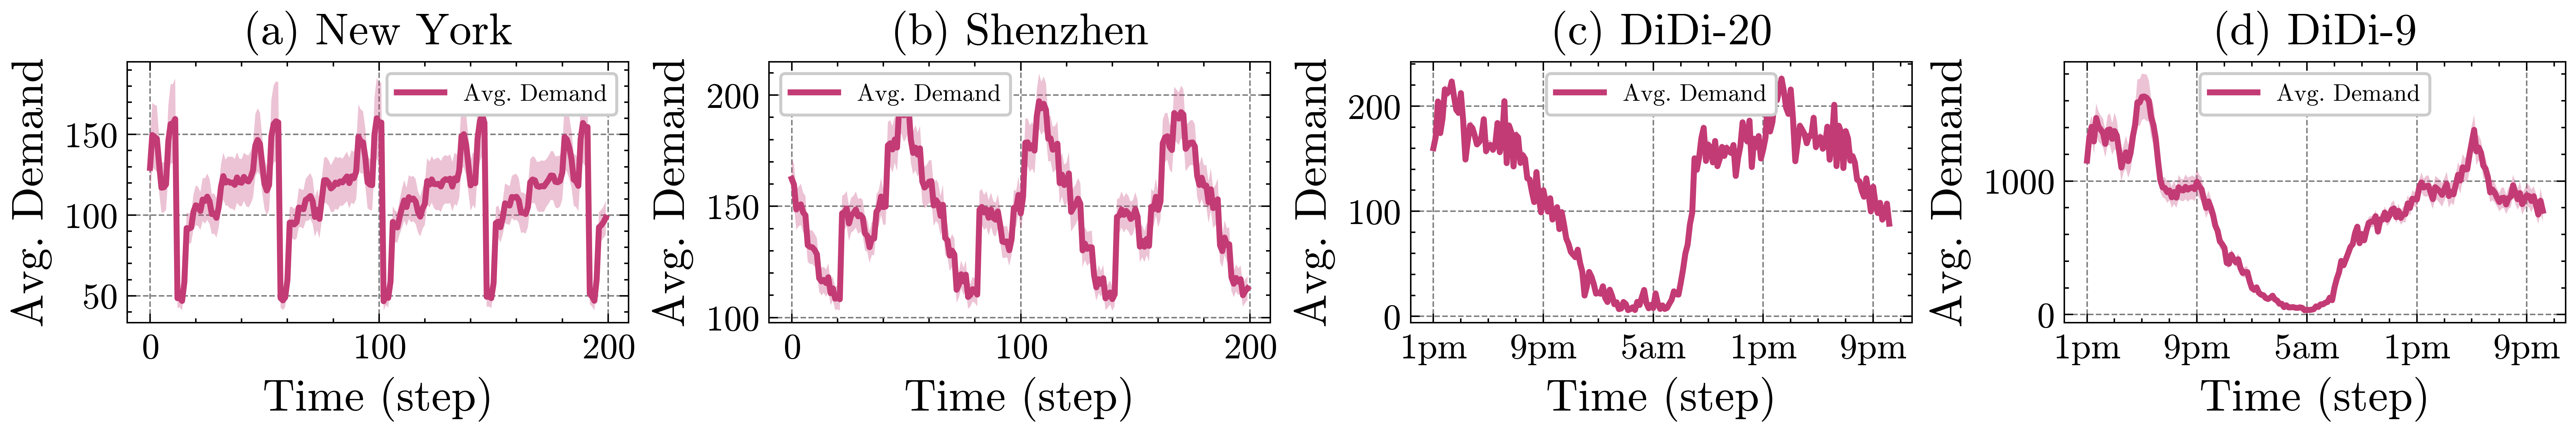

In [3]:
plt.style.use(["science", "ieee", "no-latex", "grid"])
fig, axes = plt.subplots(1, 4, dpi=dpi, figsize=(12, 2), constrained_layout=True)
# fig.subplots_adjust(hspace=0.65, wspace=0.25)

for idx, name in enumerate(dataset_names):
    path = datasets[name] / "realprice" / "dmfc" / "demands.csv"

    if not path.exists():
        continue

    with open(path, "r") as f:
        demands = pd.read_csv(f, header=None)

    config = get_config(name)
    demand_map = (
        demands.to_numpy()
        .reshape(-1, config.epi_len, config.n_regions, config.n_regions)
        .mean(axis=0)
    )
    demand_trace = demand_map.sum(axis=2)  # (L, R, R) -> (L, R)
    if demand_offset:
        demand_trace = demand_trace[25:]
        axes[idx].set_xticks(np.arange(0, 176, 25))
        axes[idx].set_xticklabels(np.arange(25, 201, 25))

    demand_avg = demand_trace.sum(axis=1)  # (L, R) -> (L)
    demand_std = demand_trace.std(axis=1)  # (L, R) -> (L)

    sns.lineplot(
        demand_avg,
        ax=axes[idx],
        color=dmfc_color,
        label="Avg. Demand",
        linewidth=line_width,
    )
    axes[idx].fill_between(
        np.arange(200),
        demand_avg - demand_std,
        demand_avg + demand_std,
        facecolor=dmfc_color,
        alpha=0.3,
    )

    if name in ["didi20", "didi9"]:
        axes[idx].set_xticks(np.arange(0, 201, 48))
        axes[idx].set_xticklabels(["1pm", "9pm", "5am", "1pm", "9pm"])
    else:
        pass

    labelsize = 15
    ticksize = 12
    axes[idx].set_xlabel("Time (step)", fontsize=labelsize)
    axes[idx].set_title(config.dataset, fontsize=labelsize)
    axes[idx].set_ylabel("Avg. Demand", fontsize=labelsize)
    axes[idx].tick_params(axis="x", labelsize=ticksize)
    axes[idx].tick_params(axis="y", labelcolor="black", labelsize=ticksize)
    # axes[idx].legend()

fig.savefig(result_path / "demands.pdf", dpi=dpi)

## Fulfillment Rate Comparison

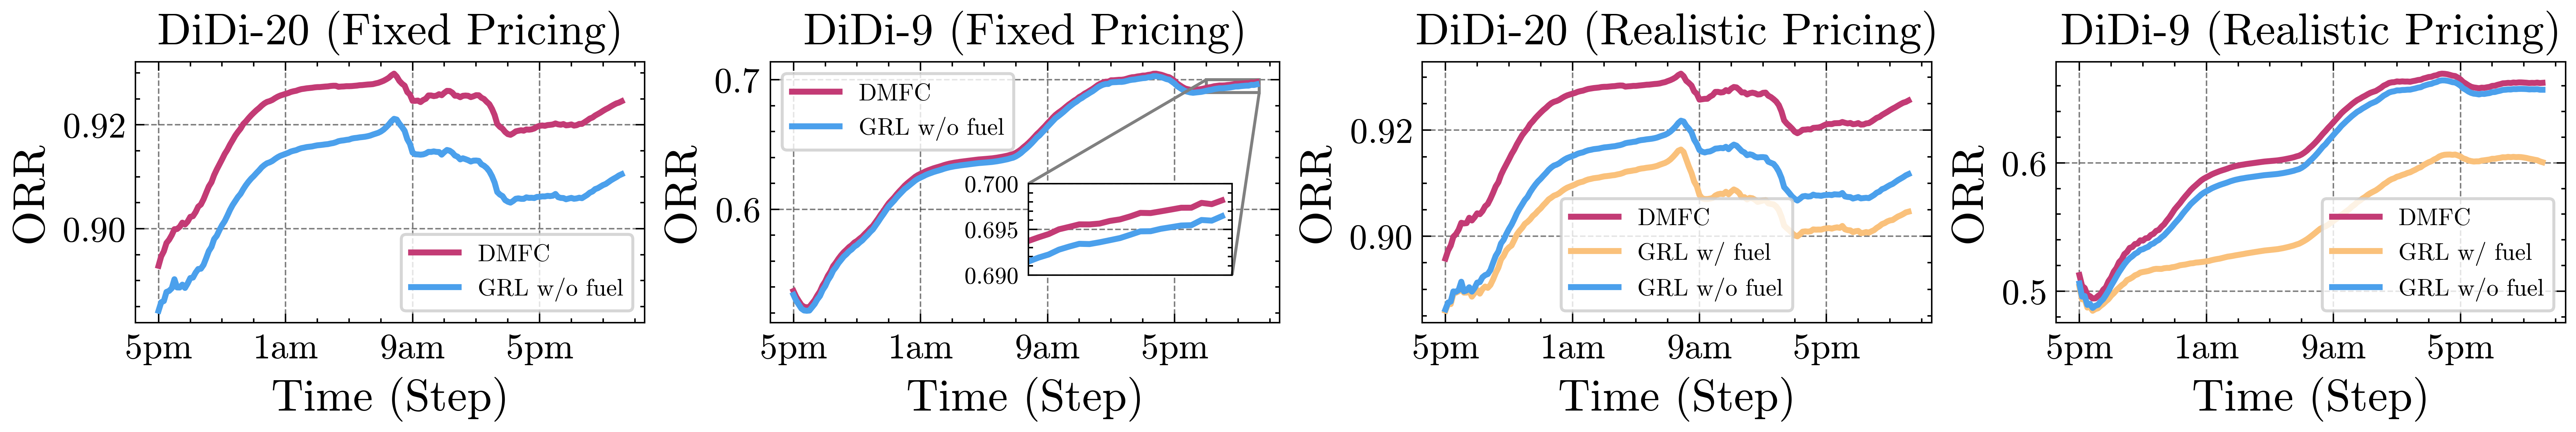

In [4]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

plt.style.use(["science", "ieee", "no-latex", "grid"])
fig, axes = plt.subplots(1, 4, dpi=dpi, figsize=(12, 2), constrained_layout=True)


# 实验配置 (行索引: 0=realprice, 1=unitprice)
experiments = [
    {
        "name": "unitprice",
        "label": "Fixed Pricing",
        "a_names": ["dmfc", "grl_nofuel"],
        "a_labels": ["DMFC", "GRL w/o fuel"],
    },
    {
        "name": "realprice",
        "label": "Realistic Pricing",
        "a_names": ["dmfc", "grl_withfuel", "grl_nofuel"],
        "a_labels": ["DMFC", "GRL w/ fuel", "GRL w/o fuel"],
    },
]

# 数据集配置 (列索引: 0=didi20, 1=didi9)
datasets_config = [
    {"name": "didi20", "label": "DiDi-20"},
    {"name": "didi9", "label": "DiDi-9"},
]

# 全局算法颜色映射 (确保颜色一致性)
global_algo_colors = {
    "dmfc": custom_cmap[0],
    "grl_nofuel": custom_cmap[1],
    "grl_withfuel": custom_cmap[2],
}

# 遍历所有实验和数据集
for expt_idx, expt in enumerate(experiments):
    for d_idx, d_config in enumerate(datasets_config):
        ax = expt_idx * len(experiments) + d_idx
        d_name = d_config["name"]
        config = get_config(d_name)
        path = datasets[d_name] / expt["name"]
        path.mkdir(parents=True, exist_ok=True)

        if d_name == "didi9" and expt["name"] == "unitprice":
            axins = inset_axes(
                axes[ax], width="40%", height="35%", loc="lower right", borderpad=2
            )

        # 绘制当前实验+数据集的所有算法
        for algo_name, algo_label in zip(expt["a_names"], expt["a_labels"]):
            file = path / algo_name / "completion_rate.csv"
            if not file.exists():
                continue

            with open(file, "r") as f:
                rate = pd.read_csv(f, header=None).to_numpy()

            avg = rate.mean(axis=0)
            std = rate.std(axis=0)

            # 应用时间偏移
            if completion_rate_offset:
                if d_name in ["didi20", "didi9"]:
                    avg = avg[24:]
                    std = std[24:]
                    axes[ax].set_xticks(np.arange(0, 200, 48))
                    axes[ax].set_xticklabels(["5pm", "1am", "9am", "5pm", "1am"])
                else:
                    avg = avg[25:]
                    std = std[25:]
                    axes[ax].set_xticks(np.arange(0, 176, 25))
                    axes[ax].set_xticklabels(np.arange(25, 201, 25))

            color = global_algo_colors[algo_name]
            sns.lineplot(
                x=range(len(avg)),
                y=avg,
                ax=axes[ax],
                color=color,
                label=algo_label,
                linewidth=line_width,
            )

            if d_name == "didi9" and expt["name"] == "unitprice":
                # 创建 inset 轴（右下角，宽高相对于主图）
                # axins = inset_axes(
                #     axes[ax], width="40%", height="35%", loc="lower right", borderpad=2
                # )

                # 你希望放大的横轴范围，比如第 50~80 个时间点
                x1, x2 = 156, 176
                axins.plot(
                    range(x1, x2),
                    avg[x1:x2],
                    color=color,
                    linewidth=line_width,
                    linestyle="solid",
                )
                # for line in axes[ax].get_lines():
                #     axins.plot(
                #         line.get_xdata(),
                #         line.get_ydata(),
                #         color=line.get_color(),
                #         linestyle=line.get_linestyle(),
                #     )

        if d_name == "didi9" and expt["name"] == "unitprice":
            # # 设置 inset 轴的刻度和范围
            axins.set_xlim(x1, x2)
            y1, y2 = 0.69, 0.70
            axins.set_ylim(y1, y2)
            axins.tick_params(labelsize=8)
            axins.set_xticks([])
            # axins.set_yticks([])

            # 可选：画线连接主图和 inset
            mark_inset(axes[ax], axins, loc1=2, loc2=4, fc="none", ec="0.5")

        # 子图标签设置
        labelsize = 15
        ticksize = 12
        axes[ax].set_xlabel("Time (Step)", fontsize=labelsize)
        axes[ax].set_ylabel("ORR", fontsize=labelsize)
        axes[ax].set_title(f"{d_config['label']} ({expt['label']})", fontsize=labelsize)
        axes[ax].tick_params(labelsize=ticksize)
        axes[ax].legend(framealpha=alpha)


# 保存合并后的图片
fig.savefig(result_path / "didi_orr.pdf", dpi=dpi, bbox_inches="tight")
fig.savefig(result_path / "didi_orr.svg", dpi=dpi, bbox_inches="tight")


In [5]:
def plot(expt_name, d_names, d_labels, a_names, a_labels, filename=None):
    assert len(a_names) == len(a_labels)
    n_subfigs = len(d_names)

    plt.style.use(["science", "ieee", "no-latex", "grid"])
    if n_subfigs == 2:
        fig, axes = plt.subplots(1, 2, dpi=dpi, figsize=(6, 2), constrained_layout=True)
        # fig.subplots_adjust(hspace=0.65, wspace=0.25)
    elif n_subfigs == 4:
        fig, axes = plt.subplots(
            1, 4, dpi=dpi, figsize=(12, 2), constrained_layout=True
        )
        # fig.subplots_adjust(hspace=0.7, wspace=0.25)
    else:
        raise ValueError("Invalid number of subfigures")

    for idx, name in enumerate(d_names):
        config = get_config(name)
        path = datasets[name]

        # if idx == 2:
        #     idx = idx % 2
        # elif idx == 4:
        #     idx = idx // 2, idx % 2

        path = path / expt_name
        path.mkdir(parents=True, exist_ok=True)

        for a_id, algo_name in enumerate(a_names):
            file = path / algo_name / "completion_rate.csv"
            if not file.exists():
                continue

            with open(file, "r") as f:
                rate = pd.read_csv(f, header=None).to_numpy()

            avg = rate.mean(axis=0)
            std = rate.std(axis=0)
            if completion_rate_offset:
                if name in ["didi20", "didi9"]:
                    avg = avg[24:]
                    std = std[24:]
                    # axes[idx].set_xticks(np.arange(0, 180, 24))
                    # axes[idx].set_xticklabels(
                    #     ["5pm", "9pm", "1am", "5am", "9am", "1pm", "5pm", "9pm"]
                    # )
                    axes[idx].set_xticks(np.arange(0, 180, 48))
                    axes[idx].set_xticklabels(["5pm", "1am", "9am", "5pm"])
                else:
                    avg = avg[25:]
                    std = std[25:]
                    axes[idx].set_xticks(np.arange(0, 176, 25))
                    axes[idx].set_xticklabels(np.arange(25, 201, 25))

            sns.lineplot(
                avg,
                ax=axes[idx],
                color=custom_cmap[a_id],
                label=a_labels[a_id],
                linewidth=line_width,
            )

            # axes[idx].set_xlabel("Time (Step)", fontsize=labelsize)
            # axes[idx].set_title(d_labels[idx], fontsize=labelsize)
            # axes[idx].set_ylabel("CORR", fontsize=labelsize)
            # axes[idx].tick_params(
            #     labelsize=ticksize, axis="both", which="major", width=1
            # )
            # axes[idx].tick_params(axis="both", which="minor", width=1)

            labelsize = 15
            ticksize = 12
            axes[idx].set_xlabel("Time (Step)", fontsize=labelsize)
            axes[idx].set_title(d_labels[idx], fontsize=labelsize)
            axes[idx].set_ylabel("ORR", fontsize=labelsize)
            axes[idx].tick_params(
                labelsize=ticksize, axis="both", which="major", width=1
            )
            axes[idx].tick_params(axis="both", which="minor", width=1)
            axes[idx].legend(framealpha=alpha)  # 0.8
            # axes[idx].legend().remove()

    # handles, labels = axes[0].get_legend_handles_labels()
    # fig.legend(
    #     handles,
    #     labels,
    #     fontsize=legendsize,
    #     # framealpha=0,
    #     framealpha=alpha,
    #     loc="center left",
    #     bbox_to_anchor=(1.0, 0.5),
    # )
    # fig.subplots_adjust(right=0.85, wspace=0.3)
    fig.savefig(result_path / f"{expt_name}_{'_'.join(d_names)}_orr.pdf", dpi=dpi)

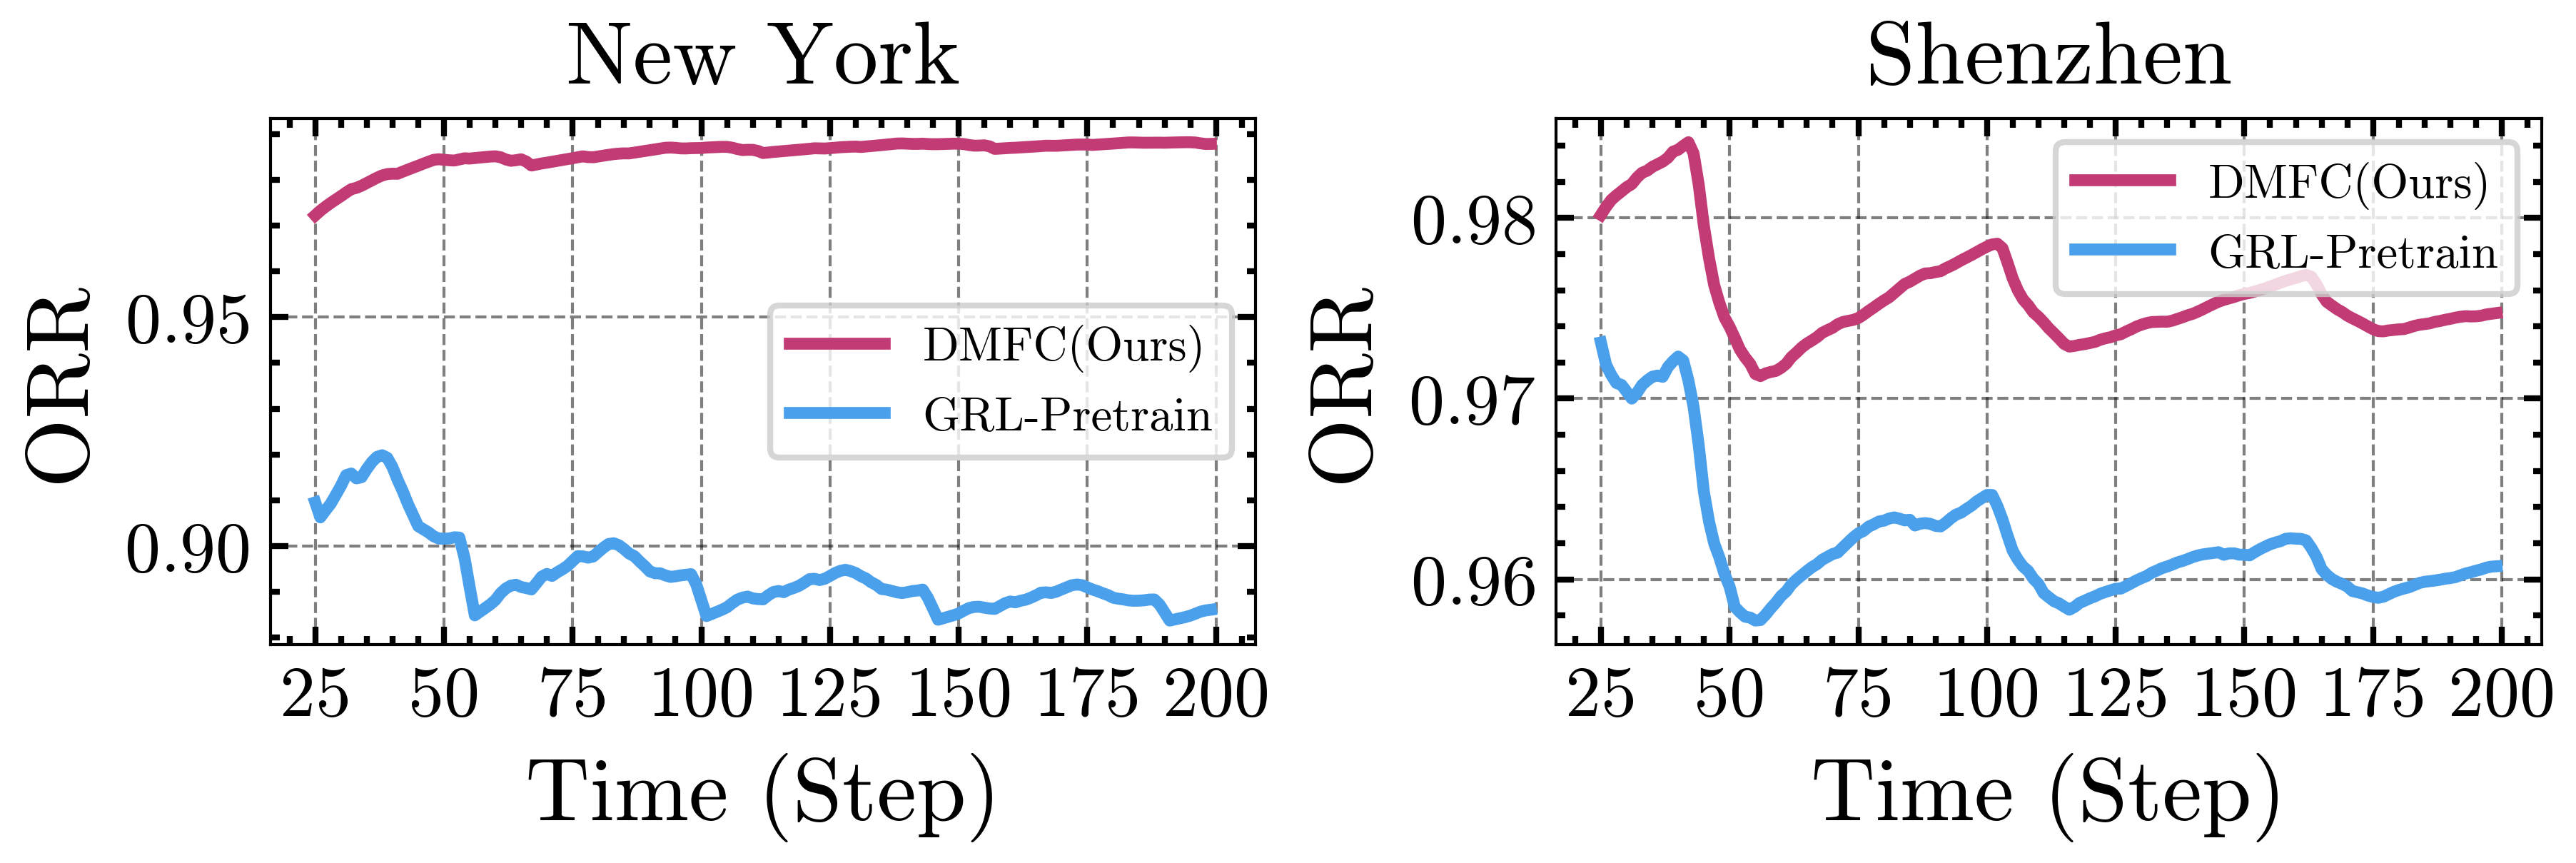

In [6]:
plot(
    expt_name="realprice",
    d_names=["nyc", "sz"],
    d_labels=["New York", "Shenzhen"],
    a_names=["dmfc", "grl_pretrained"],
    a_labels=["DMFC(Ours)", "GRL-Pretrain"],
)

In [7]:
# plot(
#     expt_name="realprice",
#     d_names=["didi20", "didi9"],
#     d_labels=["DiDi-20", "DiDi-9"],
#     a_names=["dmfc", "grl_withfuel", "grl_nofuel"],
#     a_labels=["DMFC", "GRL-withfuel", "GRL-nofuel"],
# )

In [8]:
# plot(
#     expt_name="unitprice",
#     d_names=["didi20", "didi9"],
#     d_labels=["DiDi-20", "DiDi-9"],
#     a_names=["dmfc", "grl_nofuel"],
#     a_labels=["DMFC", "GRL-nofuel"],
# )